<a href="https://colab.research.google.com/github/adesam146/nlpcw/blob/rest_of_tasks/NLP_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Check GPU memory

In [0]:
#Check GPU Memory allocation
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [0]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.9 GB  | Proc size: 142.4 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
#run this if GPU utilization is not 0%
# !kill -9 -1

## Imports

In [0]:
!pip install -U spacy ftfy torchtext
!python -m spacy download en

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import sampler
import spacy
from torchtext import data
from torchtext import datasets as nlp_dset
import random
from sklearn import metrics
from sklearn.utils import resample
import numpy as np
import pandas as pd

import torchvision.transforms as T

nlp_spaCy = spacy.load('en')

GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:"+str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

#Fix all seeds
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)


cuda:0


In [2]:
# Load datafiles from own google drive
from google.colab import drive
drive.mount('/content/drive')
train_fp = """/content/drive/My Drive/colab_data/offenseval-training-v1.tsv"""

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Use two GloVe trained on two different corpuses for comparison:
  # Glove.6B
  # glove.twitter.27B
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

## Import and preprocess Data

In [0]:
def downsample(train_df):
  #ONLY USE THIS IF YOU WANT TO DOWNSAMPLE DATA - everything should work w/o this cell
  #Select a subset of the data so that the classes are equally balanced
  #Use downsampling for now. 

  num_NOT = 8840
  num_OFF = 4400
  # Separate majority and minority classes
  df_majority = train_df[train_df["subtask_a"] == 'NOT']
  df_minority = train_df[train_df["subtask_a"] == 'OFF']

  # Downsample majority class
  df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=num_OFF,     # to match minority class
                                   random_state=123) # reproducible results

  # Combine minority class with downsampled majority class
  df_downsampled = pd.concat([df_majority_downsampled, df_minority])

  # Display new class counts
  print(df_downsampled.subtask_a.value_counts())

  df_downsampled = df_downsampled.sample(frac=1) #shuffle df

  return df_downsampled

In [0]:
def tweet_preprocess(tweet_text):
  """Add tweet specific preprocessing steps here"""
  
  #Remove 'USER' (but leave '@')
  tweet_text = tweet_text.replace("@USER", "@") 
  
  return tweet_text

def convert_labels_A(labels):
    """Preproceses and return labels"""

    final_labels = []
    for label in labels:
        assert label == "OFF" or label == "NOT", "Label should not be: {}".format(label)
    
        if label == "OFF":
            res = 1
        elif label == "NOT":
            res = 0        
        label = torch.tensor([res])
        final_labels.append(label)
    return final_labels
 

In [0]:
def transfrom_for_scikit(task_header, text_field, label_field, embedding, train):
  """
  task_header is one of subtask_a, subtask_b, subtask_c
  """
  tokenised_train = [example.tweet for example in train]
  labels = np.array(
      label_field.process(
          [getattr(example, task_header) for example in train]
      )
  )
  
  word_idxs = text_field.process(tokenised_train)
  embeddings = torch.mean(embedding(word_idxs).detach(), dim=1)
  
  return embeddings.numpy(), labels

## Utils Functions For Neural Network Classifer

In [0]:
def tokenizer(text): # create a tokenizer function for gloVe
    res = [tok.text for tok in nlp_spaCy.tokenizer(text)]
    return res

In [0]:
def check_accuracy(task_header, loader, model, conf=False):
    """
    Note at the moment this function assumes the batch size is equal to the 
    number of data in the loader when calculating the confusion matrix
    """
    num_correct = 0
    num_samples = 0
    
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            x, y = batch.tweet, getattr(batch, task_header)
            y = y.view(-1, 1)
                
            x = x.to(device=device, dtype=torch.long)  # move to  GPU
            y = y.to(device=device, dtype=torch.long)
            
            if task_header == 'subtask_c':
              pred_prob = F.softmax(model(x), dim=1)
              pred_1 = torch.argmax(pred_prob, dim=1).view(-1, 1)
            else:
              pred_prob = torch.sigmoid(model(x))
              pred_1 = (pred_prob > 0.5).type(torch.long)
              
            num_correct += (pred_1 == y).sum()
            num_samples += pred_prob.size(0)
            
            # move to CPU to prevent memory overflow and calculate metrics
            x = x.to(device="cpu", dtype=torch.long)
            y = y.to(device="cpu", dtype=torch.long).numpy()
            pred_1 = pred_1.to(device="cpu", dtype=torch.long).numpy()
            
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        if conf:
            print(metrics.confusion_matrix(y, pred_1))
            print(metrics.classification_report(y, pred_1))

In [0]:
def check_loss(task_header, loader, model, loss_fn):
  model.eval()
  with torch.no_grad():
    loss = 0
    for idx, batch in enumerate(loader):
      x, y = batch.tweet, getattr(batch, task_header)
      
      x = x.to(device=device, dtype=torch.long) 
      y = y.to(device=device, dtype=torch.long if task_header == 'subtask_c' else torch.float)
      
      logits = model(x)
      
      loss += loss_fn(logits, y.view(-1,) if isinstance(loss_fn, nn.CrossEntropyLoss) else y.view(-1, 1))
      
    return loss/len(loader)

In [0]:
def train_helper(task_header, model, optimizer, train_loader, 
               valid_loader, epochs=1, loss_fn=F.binary_cross_entropy_with_logits, print_every=50):
    """
    Train a model
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to GPU
    
    training_losses = []
    validation_losses = []
    try:
        for epoch in range(epochs):
            print("Epoch:", epoch)
            total_loss = 0
            for batch_idx, batch in enumerate(train_loader):

                model.train()  # put model to training mode
                
                inputs, targets = batch.tweet, getattr(batch, task_header)
                
                x = inputs.to(device=device, dtype=torch.long)  # move to device, e.g. GPU
                y = targets.to(device=device, dtype=torch.long if task_header == 'subtask_c' else torch.float) #this should be a float cross entropy
                #x = inputs
                #y = targets
                logits = model(x)
                
                # When using cross_entropy the targets need to have a shape (N,)
                # However, for BCEWithLogits they just need
                # to have the same shape as the logits
                loss = loss_fn(logits, y.view(-1,) if isinstance(loss_fn, nn.CrossEntropyLoss) else y.view(-1, 1))
                # Zero out all of the gradients for the variables which the optimizer
                # will update.
                optimizer.zero_grad()

                # This is the backwards pass: compute the gradient of the loss with
                # respect to each  parameter of the model.
                loss.backward()

                # Actually update the parameters of the model using the gradients
                # computed by the backwards pass.
                optimizer.step()

                x = x.to(device="cpu", dtype=torch.long)  # move to CPU to prevent memory overflow
                y = y.to(device="cpu", dtype=torch.long)

                total_loss += loss.detach().item()
                
                if batch_idx % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (batch_idx, loss.item()))
            
            training_losses.append(total_loss/len(train_iterator))
            print()
            print("Validation Accuracy:")
            check_accuracy(task_header, valid_loader, model, conf=True)
            valid_loss = check_loss(task_header, valid_loader, model, loss_fn)
            validation_losses.append(valid_loss)
            print()
        return training_losses, validation_losses
    except Exception as e:
        #Attempt to prevent GPU memory overflow by transferring model back to cpu
        #model = model.to(device="cpu")
        raise e    

## Neural Network Classifiers

In [0]:
#embedding (lookup layer) layer
class SimpleClassifierGloVe(nn.Module):
    """Glove w. 2d conv"""
    
    def __init__(self, vocab, embedding_dim, window_size, out_channels, dropout, num_classes=2):
        
        super(SimpleClassifierGloVe, self).__init__()
        
        
        self.vocab = vocab
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.embedding.weight.data.copy_(vocab.vectors) # copies pre-trained word vectors

        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size, embedding_dim))

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(out_channels, 1 if num_classes == 2 else num_classes)

        #Kaming normalization
        nn.init.kaiming_normal_(self.conv.weight)
        nn.init.kaiming_normal_(self.fc.weight)

        
        
    def forward(self, x, ):
        
        embedded = self.embedding(x)
                
        #(batch size, max sent length, embedding dim)
        
        #images have 3 RGB channels 
        #for the text we add 1 channel
        embedded = embedded.unsqueeze(1)
        
        #(batch size, 1, max sent length, embedding dim)
        
        feature_maps =  F.relu(self.conv(embedded).squeeze(3))
        # (batch size, out_channels, max sent length - window size +1, 1)
        # -> (batch size, out_channels, max sent length - window size +1)
           
        #the max pooling layer
        pooled = F.max_pool1d(feature_maps, feature_maps.shape[2]).squeeze(2)
        # (batch size, out_channels)      
        
        # Do batch normalize pooled then at sentiment
        
        return self.fc(self.dropout(pooled))

## Task A

In [91]:
#Create fields
BATCH_SIZE = 128


TEXT = data.Field(sequential=True, tokenize=tokenizer, lower=True, batch_first = True)
LABEL = data.LabelField(sequential=False, use_vocab=True, batch_first = True)
ID = data.LabelField(sequential=False, use_vocab=False, batch_first=True)

data_fields = [('id', ID), 
               ('tweet', TEXT),
               ('subtask_a',LABEL),
               ('subtask_b',LABEL),
               ('subtask_c',LABEL)]


train = data.TabularDataset(train_fp, format='TSV', fields = 
                            data_fields, skip_header=True, filter_pred=None)

train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f'Train size: {len(train)}')
print(f'Validation size: {len(valid)}')

#Now build vocab (using only the training set)
TEXT.build_vocab(train, vectors='glove.twitter.27B.200d') #USE "glove.840B.300d" or glove.twitter.27B.200d

LABEL.build_vocab(train.subtask_a)

output_dim = len(LABEL.vocab)

#Create iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                        batch_sizes=(BATCH_SIZE, len(valid)),  
                        sort_key=lambda x: len(x.tweet), device=device)

# For retrieving tweet text later on
train_df = pd.read_csv(train_fp, delimiter="\t")

Train size: 10592
Validation size: 2648


In [21]:
print('first tweet', train[0].tweet)
print('first label', train[0].subtask_a)
print("first tweet id:", train[0].id)
# print(TEXT.vocab.stoi) # word to index
# print(LABEL.vocab.stoi) # label to index

first tweet ['@user', '@user', 'a', 'must', 'read', '!', 'url']
first label NOT
first tweet id: 29719


In [22]:
#check loader
for idx, batch in enumerate(train_iterator):
    inputs, labels = batch.tweet, batch.subtask_a
    print(inputs.shape)
    print(labels.shape)
    print(len(train_iterator))
    break

torch.Size([128, 74])
torch.Size([128])
83


In [23]:
#CONV with Glove
embedding_dim = 200
window_size = 3
lr = 0.00025
out_channels = 100
dropout = 0.5

model = SimpleClassifierGloVe(TEXT.vocab,
                              embedding_dim,
                              window_size,
                              out_channels,
                              dropout)

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()

t_losses, v_losses = train_helper('subtask_a',
                                  model,
                                  optimizer,
                                  loss_fn = loss_fn,
                                  epochs = 20,
                                  train_loader=train_iterator,
                                  valid_loader=valid_iterator)

Epoch: 0
Iteration 0, loss = 1.0084
Iteration 50, loss = 0.8035

Validation Accuracy:
Got 1821 / 2648 correct (68.77)
[[1718   55]
 [ 772  103]]
              precision    recall  f1-score   support

           0       0.69      0.97      0.81      1773
           1       0.65      0.12      0.20       875

   micro avg       0.69      0.69      0.69      2648
   macro avg       0.67      0.54      0.50      2648
weighted avg       0.68      0.69      0.61      2648


Epoch: 1
Iteration 0, loss = 0.7128
Iteration 50, loss = 0.6590

Validation Accuracy:
Got 1868 / 2648 correct (70.54)
[[1712   61]
 [ 719  156]]
              precision    recall  f1-score   support

           0       0.70      0.97      0.81      1773
           1       0.72      0.18      0.29       875

   micro avg       0.71      0.71      0.71      2648
   macro avg       0.71      0.57      0.55      2648
weighted avg       0.71      0.71      0.64      2648


Epoch: 2
Iteration 0, loss = 0.6487
Iteration 50, loss

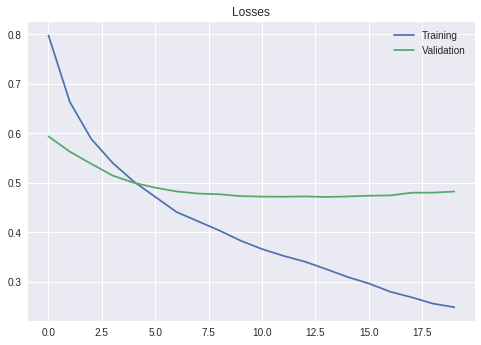

In [25]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(t_losses, label='Training')
ax1.plot(v_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

plt.show()

In [0]:
embedding = nn.Embedding(len(TEXT.vocab), embedding_dim)
embedding.weight.data.copy_(TEXT.vocab.vectors) # copies pre-trained word vectors

training_embeddings, training_labels = transfrom_for_scikit('subtask_a', TEXT, LABEL, embedding, train)

In [105]:
from sklearn import svm
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge', penalty='l1',
                          alpha=1e-3, random_state=42,
                          max_iter=20, tol=None, class_weight={1: 2})

clf.fit(training_embeddings, training_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.001, average=False, class_weight={1: 2},
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=20,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
val_embeddings, val_labels = transfrom_for_scikit('subtask_a', TEXT, LABEL, embedding, valid)

In [107]:
preds = clf.predict(val_embeddings)

print(metrics.confusion_matrix(val_labels, preds))
print(metrics.classification_report(val_labels, preds))
print("Accuracy:", metrics.accuracy_score(val_labels, preds))

[[1426  347]
 [ 476  399]]
              precision    recall  f1-score   support

           0       0.75      0.80      0.78      1773
           1       0.53      0.46      0.49       875

   micro avg       0.69      0.69      0.69      2648
   macro avg       0.64      0.63      0.63      2648
weighted avg       0.68      0.69      0.68      2648

Accuracy: 0.6891993957703928


## Task B

In [26]:
#Create fields
BATCH_SIZE = 128


TEXT = data.Field(sequential=True, tokenize=tokenizer, lower=True, batch_first=True)
LABEL = data.LabelField(sequential=False, use_vocab=True, batch_first = True)
ID = data.LabelField(sequential=False, use_vocab=False, batch_first=True)

data_fields = [('id', ID), 
               ('tweet', TEXT),
               ('subtask_a', LABEL),
               ('subtask_b',LABEL)
              ]

train = data.TabularDataset(train_fp,
                            format='TSV',
                            fields=data_fields,
                            skip_header=True,
                            filter_pred=lambda d: d.subtask_a == 'OFF')

train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f'Train size: {len(train)}')
print(f'Validation size: {len(valid)}')

#Now build vocab (using only the training set)
# This is where tokenization is performed on train
TEXT.build_vocab(train, vectors='glove.twitter.27B.200d')

LABEL.build_vocab(train.subtask_b)

output_dim = len(LABEL.vocab)

print(LABEL.vocab.stoi)

#Create iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                        batch_sizes=(BATCH_SIZE, len(valid)),  
                        sort_key=lambda x: len(x.tweet), device=device)

Train size: 3520
Validation size: 880
defaultdict(<function _default_unk_index at 0x7fee2eecb6a8>, {'TIN': 0, 'UNT': 1})


In [27]:
#CONV with Glove
embedding_dim = 200
window_size = 3
lr = 0.00025
out_channels = 100
dropout = 0.5

model = SimpleClassifierGloVe(TEXT.vocab, embedding_dim, window_size, out_channels, dropout)

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()


t_losses, v_losses = train_helper('subtask_b',
                                  model,
                                  optimizer,
                                  loss_fn = loss_fn,
                                  epochs = 20,
                                  train_loader=train_iterator,
                                  valid_loader=valid_iterator)

Epoch: 0
Iteration 0, loss = 0.7425

Validation Accuracy:
Got 768 / 880 correct (87.27)
[[768   0]
 [112   0]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       768
           1       0.00      0.00      0.00       112

   micro avg       0.87      0.87      0.87       880
   macro avg       0.44      0.50      0.47       880
weighted avg       0.76      0.87      0.81       880


Epoch: 1
Iteration 0, loss = 0.4688


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Validation Accuracy:
Got 768 / 880 correct (87.27)
[[768   0]
 [112   0]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       768
           1       0.00      0.00      0.00       112

   micro avg       0.87      0.87      0.87       880
   macro avg       0.44      0.50      0.47       880
weighted avg       0.76      0.87      0.81       880


Epoch: 2
Iteration 0, loss = 0.3960

Validation Accuracy:
Got 768 / 880 correct (87.27)
[[768   0]
 [112   0]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       768
           1       0.00      0.00      0.00       112

   micro avg       0.87      0.87      0.87       880
   macro avg       0.44      0.50      0.47       880
weighted avg       0.76      0.87      0.81       880


Epoch: 3
Iteration 0, loss = 0.2444

Validation Accuracy:
Got 769 / 880 correct (87.39)
[[768   0]
 [111   1]]
              precision    recall  f1-score   s

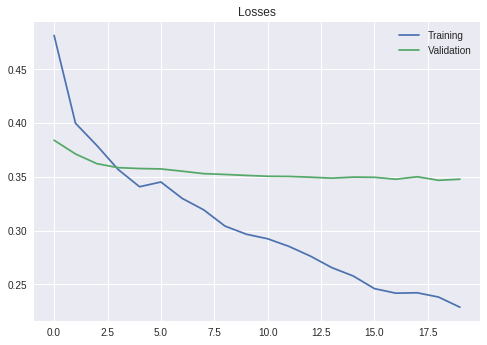

In [28]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(t_losses, label='Training')
ax1.plot(v_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

plt.show()

##Task C

In [29]:
#Create fields
BATCH_SIZE = 128


TEXT = data.Field(sequential=True, tokenize=tokenizer, lower=True, batch_first = True)
LABEL = data.LabelField(sequential=False, use_vocab=True, batch_first = True)
ID = data.LabelField(sequential=False, use_vocab=False, batch_first=True)

data_fields = [('id', ID), 
               ('tweet', TEXT),
               ('subtask_a', LABEL),
               ('subtask_b',LABEL),
               ('subtask_c', LABEL)
              ]

train = data.TabularDataset(train_fp,
                            format='TSV',
                            fields=data_fields,
                            skip_header=True,
                            filter_pred=lambda d: d.subtask_a == 'OFF' and d.subtask_b == 'TIN')

train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f'Train size: {len(train)}')
print(f'Validation size: {len(valid)}')

#Now build vocab (using only the training set)
TEXT.build_vocab(train, vectors='glove.twitter.27B.200d')

LABEL.build_vocab(train.subtask_c)

output_dim = len(LABEL.vocab)

print(LABEL.vocab.stoi)

#Create iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                        batch_sizes=(BATCH_SIZE, len(valid)),  
                        sort_key=lambda x: len(x.tweet), device=device)

Train size: 3101
Validation size: 775
defaultdict(<function _default_unk_index at 0x7fee2eecb6a8>, {'IND': 0, 'GRP': 1, 'OTH': 2})


In [89]:
#CONV with Glove
embedding_dim = 200
window_size = 3
lr = 0.00025
out_channels = 100
dropout = 0.5

model = SimpleClassifierGloVe(TEXT.vocab,
                              embedding_dim,
                              window_size,
                              out_channels,
                              dropout,
                              num_classes=3)

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.CrossEntropyLoss()


t_losses, v_losses = train_helper('subtask_c',
                                  model, optimizer,
                                  loss_fn = loss_fn,
                                  epochs = 30,
                                  train_loader=train_iterator,
                                  valid_loader=valid_iterator)

Epoch: 0
Iteration 0, loss = 1.8731

Validation Accuracy:
Got 477 / 775 correct (61.55)
[[469   7   0]
 [199   8   0]
 [ 87   5   0]]
              precision    recall  f1-score   support

           0       0.62      0.99      0.76       476
           1       0.40      0.04      0.07       207
           2       0.00      0.00      0.00        92

   micro avg       0.62      0.62      0.62       775
   macro avg       0.34      0.34      0.28       775
weighted avg       0.49      0.62      0.49       775


Epoch: 1
Iteration 0, loss = 1.5259


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Validation Accuracy:
Got 497 / 775 correct (64.13)
[[458  18   0]
 [168  39   0]
 [ 78  14   0]]
              precision    recall  f1-score   support

           0       0.65      0.96      0.78       476
           1       0.55      0.19      0.28       207
           2       0.00      0.00      0.00        92

   micro avg       0.64      0.64      0.64       775
   macro avg       0.40      0.38      0.35       775
weighted avg       0.55      0.64      0.55       775


Epoch: 2
Iteration 0, loss = 1.1229

Validation Accuracy:
Got 512 / 775 correct (66.06)
[[457  19   0]
 [152  55   0]
 [ 76  16   0]]
              precision    recall  f1-score   support

           0       0.67      0.96      0.79       476
           1       0.61      0.27      0.37       207
           2       0.00      0.00      0.00        92

   micro avg       0.66      0.66      0.66       775
   macro avg       0.43      0.41      0.39       775
weighted avg       0.57      0.66      0.58       775


Epoc

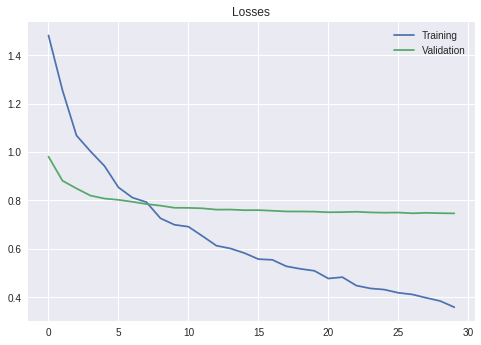

In [90]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(t_losses, label='Training')
ax1.plot(v_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

plt.show()

In [0]:
embedding = nn.Embedding(len(TEXT.vocab), embedding_dim)
embedding.weight.data.copy_(TEXT.vocab.vectors) # copies pre-trained word vectors

embeddings, training_labels = transfrom_for_scikit('subtask_c', TEXT, LABEL, embedding, train)

In [0]:
val_embeddings, val_labels = transfrom_for_scikit('subtask_c', TEXT, LABEL, embedding, valid)

In [64]:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

# clf = svm.SVC()
# clf = SGDClassifier(loss='hinge', penalty='l1',
#                           alpha=1e-3, random_state=42,
#                           max_iter=5, tol=None, class_weight={2.0: 1})

from sklearn.ensemble import AdaBoostClassifier

# The decision trees have max_depth 1
clf = AdaBoostClassifier(n_estimators=100)

clf.fit(embeddings, training_labels)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=10, random_state=None)

In [65]:
preds = clf.predict(val_embeddings)

print(metrics.confusion_matrix(val_labels, preds))
print(metrics.classification_report(val_labels, preds))
print("Accuracy:", metrics.accuracy_score(val_labels, preds))

[[412  63   1]
 [ 95 110   2]
 [ 53  36   3]]
              precision    recall  f1-score   support

           0       0.74      0.87      0.80       476
           1       0.53      0.53      0.53       207
           2       0.50      0.03      0.06        92

   micro avg       0.68      0.68      0.68       775
   macro avg       0.59      0.48      0.46       775
weighted avg       0.65      0.68      0.64       775

Accuracy: 0.6774193548387096
